# Customizing LayoutParser Models with Label Studio Annotation
*With Scientific Document Parsing as an example*


## Prerequisite

This tutorial assumes you know about 

- Intermediate Python  

## Introduction 

### Objectives & Task Overview 

Please see the attached slides [here](https://szj.io/assets/files/talks/2022-Feb-LayoutParser-and-Label-Studio-Webinar.pdf). 

### Detailed Steps 

1. **Define the problem**
    - What is the extraction target? 
    - What can existing models do? 
    - Do we have available dataset? 
2. **Create the Training Dataset**
    - Obtain the datasets 
    - Set up Label Studio 
    - Define the Annotation Schema  
    - Annotate and Save 
3. **Train Layout Models**
    - Set up the Machines 
    - Train Test Split 
    - Run the LayoutPaser Model Training script
4. **Utilize New Layout Models**
    - Load Layout Models 
    - Parse the outputs based on Layout Models 

## I. Define the Problem 

### Extraction Target 

Bibliogrophy item parsing is an important task in scientific document understanding. We want to extract individual bibliogrophy items from the source documents. For example, for the page on the left, we'd like to segment it into "blocks" shown on the right. 

![task-overview.png](task-overview.png)

### Existing Models 

The PubLayNet models maybe the most straightfoward ones to try with: 

In [1]:
import requests
import layoutparser as lp

In [2]:
pdf_tokens, pdf_images = lp.load_pdf(r"C:\Users\lante\Downloads\docs\01_intro_ml.pdf", load_images=True)

Find a model from the [LayoutParser Open Platform](https://layout-parser.github.io/platform/)

### Existing Datasets? 

:( 

## II. Create a Training Dataset

### Obtain the Source Data 


### Set up Label Studio 

Please follow the instructions on the [Label Studio Github Repo](https://github.com/heartexlabs/label-studio). I used the following configurations for setting up the annotation task. 

```bash 
# Installation 
git clone https://github.com/heartexlabs/label-studio.git
pip install -e .

# Starting the service 
python label_studio/manage.py migrate
python label_studio/manage.py runserver
```

After starting Label Studio on your local machine, you can click [here](http://localhost:8080/) for the running service.

Also here is the used labelstudio interface config:

```html
<View style="display: flex;">
  <View style="width: 600px">
    <Image name="image" value="$image"/>
  </View>
  
  <View style="width: 150px; padding: 0 1em; margin-right: 0.5em; background: #f1f1f1; border-radius: 3px">
  <RectangleLabels name="label" toName="image">
    <Label value="BibItem" background="#FFA39E"></Label>
  </RectangleLabels>
  </View>
</View>
```

### Downlaod the Annotation Examples  

You can run `download_annotation.py` in this folder to download the annotation data:

```bash
# pip install layoutparser
python download_annotation.py 
```

It will download a small subset of data for demostration purpose, and you might need to label more samples in practice to train a better model. 

### Check the Annotated Data 

The script is based on this [layout parser example tutorial](https://layout-parser.readthedocs.io/en/latest/example/load_coco/index.html).

In [7]:
from pycocotools.coco import COCO
import layoutparser as lp
import random
import cv2

def load_coco_annotations(annotations, coco=None):
    """
    Args:
        annotations (List):
            a list of coco annotaions for the current image
        coco (`optional`, defaults to `False`):
            COCO annotation object instance. If set, this function will
            convert the loaded annotation category ids to category names
            set in COCO.categories
    """
    layout = lp.Layout()

    for ele in annotations:

        x, y, w, h = ele['bbox']

        layout.append(
            lp.TextBlock(
                block = lp.Rectangle(x, y, w+x, h+y),
                type  = ele['category_id'] if coco is None else coco.cats[ele['category_id']]['name'],
                id = ele['id']
            )
        )

    return layout

In [15]:
COCO_ANNO_PATH = 'project-2-at-2024-01-21-15-34-564ef14c/result.json'
COCO_IMG_PATH  = 'project-2-at-2024-01-21-15-34-564ef14c/'

coco = COCO(COCO_ANNO_PATH)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


C:\Users\lante\AppData\Local\Temp\ipykernel_28004\4235025259.py:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for image_id in random.sample(coco.imgs.keys(), 2):


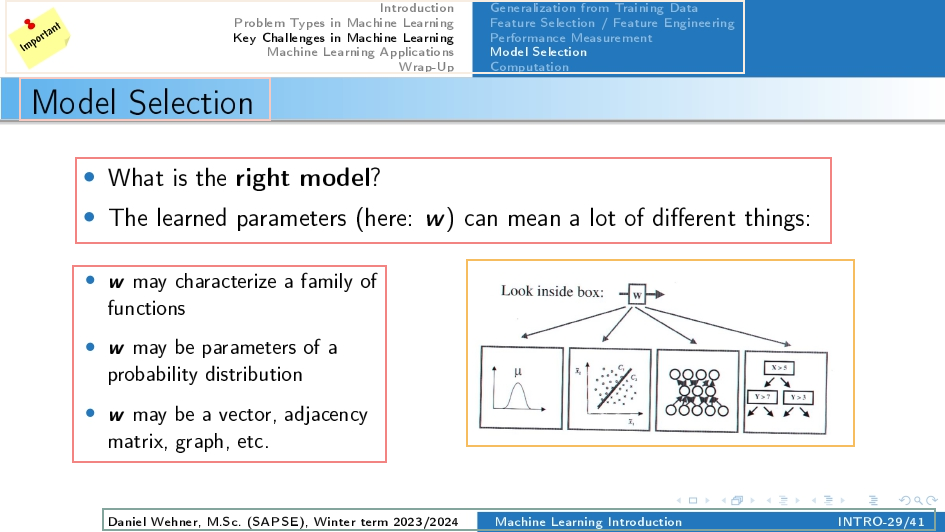

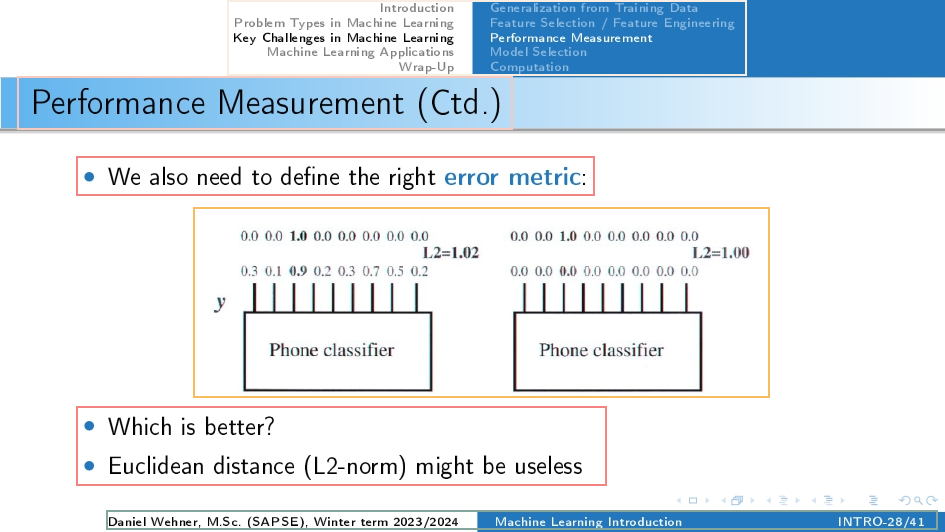

In [16]:
for image_id in random.sample(coco.imgs.keys(), 2):
    image_info = coco.imgs[image_id]
    annotations = coco.loadAnns(coco.getAnnIds([image_id]))

    image = cv2.imread(f'{COCO_IMG_PATH}/{image_info["file_name"]}')
    layout = load_coco_annotations(annotations, coco)

    viz = lp.draw_box(image[...,::-1], layout)
    display(viz) # show the results

### [Optional] Define the Annotation Schema 

- Rethink why models are needed? 
- Labeling Schema
  - Go through examples
    - Gather >30 diverse examples from the task
    - Go through them and take notes 
      - Keep an eye on what are the uniquely different types of segments to be predicted?
  - Define the classes 
    - Write definition based on visual features as clear as you can 
      - Good example:
        - The title block should be a short piece of bold text; it usually have one line or two; it usually appear at the first page of the document 
      - Bad example:
        - Annotate the document title region as a title block 
    - Add image examples 
      - If possible, also include ambiguous or counter examples 

### [Optional] Advanced Topic: Active Learning 

You can find more about this topic in [our recent paper](https://arxiv.org/pdf/2010.01762.pdf).

## III. Layout Model Training 

```bash
git clone git@github.com:Layout-Parser/layout-model-training.git
```

### Train-Test Split 

```bash
python cocosplit.py \                                  
    --annotation-path     ../data/bib/result.json \
    --split-ratio         0.85 \
    --train               ../data/bib/train.json \
    --test                ../data/bib/test.json 
```

### Run Training 

1. Modify the `train_bib.sh` script 
2. Run the following command

    ```bash
    bash train_bib.sh
    ```

## IV. Use of the Layout Models 

### Load Newly Trained Layout Models 

In [3]:
model = lp.Detectron2LayoutModel(
    config_path = r"C:\Users\lante\layout-model-training\outputs\fast_rcnn\config.yaml",
    model_path = r"C:\Users\lante\layout-model-training\outputs\fast_rcnn\model_final.pth",
    extra_config = ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.3] # <-- Only output high accuracy preds
)

In [17]:
layout = model.detect(pdf_images[15])

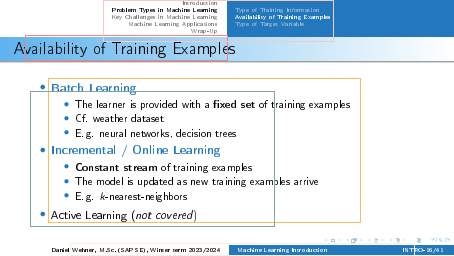

In [18]:
test = lp.draw_box(pdf_images[15], layout)
display(test)

In [7]:
layout

Layout(_blocks=[TextBlock(block=Rectangle(x_1=15.691393852233887, y_1=37.28899002075195, x_2=208.55654907226562, y_2=60.11865997314453), text=None, id=None, type=4, parent=None, next=None, score=0.9857314229011536), TextBlock(block=Rectangle(x_1=83.22724151611328, y_1=78.81568908691406, x_2=371.7296447753906, y_2=225.29080200195312), text=None, id=None, type=3, parent=None, next=None, score=0.983454704284668), TextBlock(block=Rectangle(x_1=25.990421295166016, y_1=36.921165466308594, x_2=121.41744232177734, y_2=61.599037170410156), text=None, id=None, type=4, parent=None, next=None, score=0.6273447871208191), TextBlock(block=Rectangle(x_1=111.0645751953125, y_1=0.0, x_2=325.71881103515625, y_2=41.746437072753906), text=None, id=None, type=2, parent=None, next=None, score=0.4274088740348816), TextBlock(block=Rectangle(x_1=63.46232604980469, y_1=245.16502380371094, x_2=405.21820068359375, y_2=255.99998474121094), text=None, id=None, type=1, parent=None, next=None, score=0.3280469179153442